In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [4]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [30]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
        self._gw_loss = 0.
        self.gw = torch.randn(784, 784)
        self.gw_var = Variable(self.gw, requires_grad=True)
        self.gw_optim = optim.Adam([self.gw_var], lr=1e-3)
        
        #for p in self.parameters():
            #print ("P=", p.shape) 
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
    
    def gw_loss(self, x, target, **kwargs):      
        self._gw_loss = F.mse_loss(x, target, **kwargs)
        return self._gw_loss

In [31]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [17]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [18]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [19]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.955864 32: 0.948106 64: 0.956732
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.507571 32: 0.419571 64: 0.359906
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.326881 32: 0.307132 64: 0.295482
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.290416 32: 0.282486 64: 0.276205
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.243384 32: 0.237555 64: 0.233156
Test set:
16: loss: 0.2813	pho_loss: 0.0032
32: loss: 0.2770	pho_loss: 0.0033
64: loss: 0.2730	pho_loss: 0.0033

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.292312 32: 0.288262 64: 0.284145
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.283725 32: 0.280914 64: 0.278339
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.270020 32: 0.267240 64: 0.266165
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.270357 32: 0.266777 64: 0.267367
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.230018 32: 0.225207 64: 0.229105
Test set:
16: loss: 0.2616	pho_loss: 0.0031
32: loss: 0.2581	pho_loss: 0.0031
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.135853 32: 0.117434 64: 0.109805
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.137364 32: 0.116892 64: 0.111352
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.147314 32: 0.125167 64: 0.117112
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.162652 32: 0.139450 64: 0.131290
Test set:
16: loss: 0.1419	pho_loss: 0.0032
32: loss: 0.1199	pho_loss: 0.0032
64: loss: 0.1128	pho_loss: 0.0031

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.140161 32: 0.119108 64: 0.112689
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.146971 32: 0.123730 64: 0.116544
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.132891 32: 0.111794 64: 0.105958
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.126605 32: 0.105735 64: 0.099215
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.118234 32: 0.098515 64: 0.096589
Test set:
16: loss: 0.1371	pho_loss: 0.0032
32: loss: 0.1159	pho_loss: 0.0032
64: loss: 0.1078	pho_loss: 0.0031

Train Epoch: 19 [0/50000 (0%)]	Losses 1

In [20]:
torch.save(models['64'], './model_64_kl_gn1')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [32]:
model = torch.load('./model_64_kl_gn1')

In [33]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  7,   6,   3,   7,   5,   5,   2,   4,   3,   4,   5,   0,
          6,   6,   5,   3,   5,   4,   6,   3,   9,   8,   2,   4,
          3,   4,   8,   4,   6,   6,   4,   6,   8,   1,   5,   3,
          3,   5,   1,   6,   5,   4,   4,   1,   3,   4,   6,   3,
          5,   4,   4,   2,   5,   4,   3,   5,   4,   3,   6,   5,
         11,   1,   1,   2])


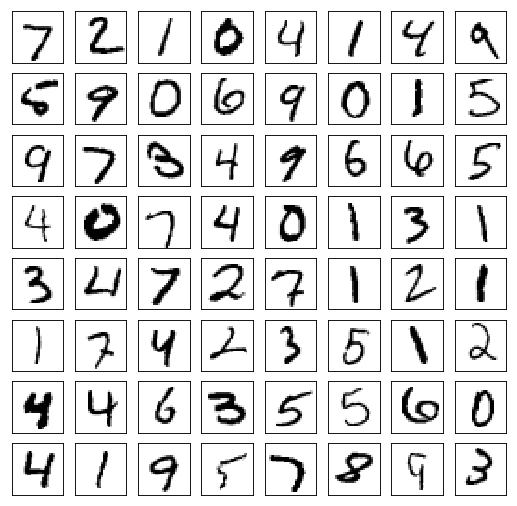

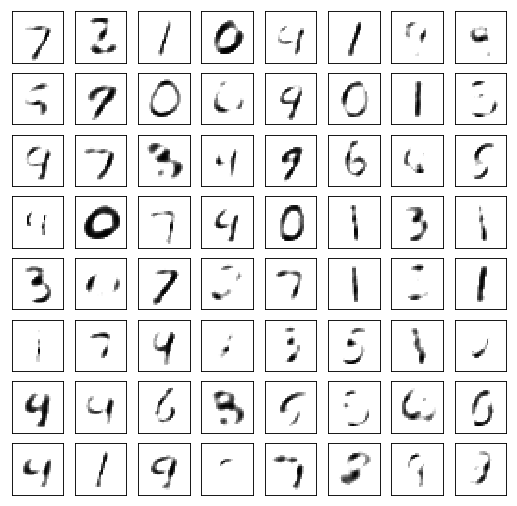

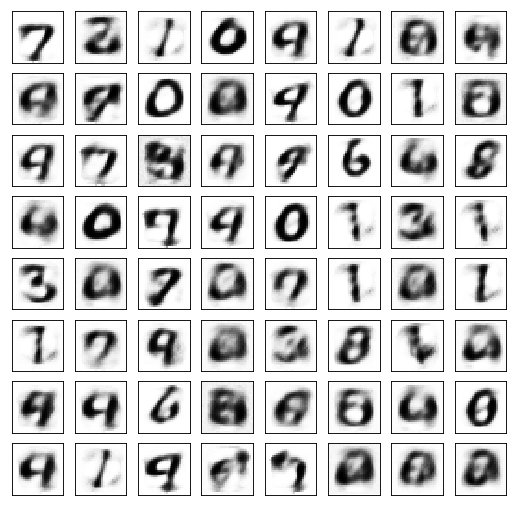

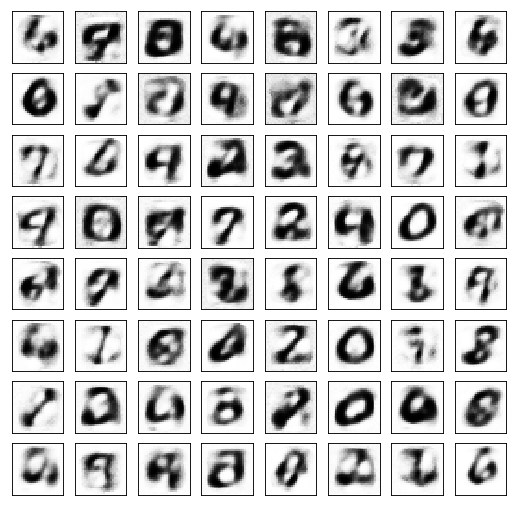

In [34]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [45]:
def train_gw(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        model.gw_var = Variable(data, requires_grad=True)
        model.gw_optim.zero_grad()        
        output = model.E(data.view(-1, 28*28))
        latent_vector = torch.eye(model.latent_size) 
            
        # Используем только "полные" батчи
        if data.shape[0] == latent_vector.shape[0]:      
            loss = model.gw_loss(output, latent_vector)
            loss.backward()
            model.gw_optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' : {:.6f}'.format(model._gw_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' : {:.6f}'.format(model._gw_loss.item())
       
        print(line + losses)


In [46]:
for epoch in range(1, 21):
    model.train()
    train_gw(epoch, models, train_log)

Train Epoch: 1 [0/50000 (0%)]	Losses  : 0.025437
Train Epoch: 1 [12800/50000 (26%)]	Losses  : 0.026956
Train Epoch: 1 [25600/50000 (51%)]	Losses  : 0.025100
Train Epoch: 1 [38400/50000 (77%)]	Losses  : 0.024661
Train Epoch: 1 [12512/50000 (100%)]	Losses  : 0.024437
Train Epoch: 2 [0/50000 (0%)]	Losses  : 0.024896
Train Epoch: 2 [12800/50000 (26%)]	Losses  : 0.024719
Train Epoch: 2 [25600/50000 (51%)]	Losses  : 0.025696
Train Epoch: 2 [38400/50000 (77%)]	Losses  : 0.026261
Train Epoch: 2 [12512/50000 (100%)]	Losses  : 0.025931
Train Epoch: 3 [0/50000 (0%)]	Losses  : 0.024886
Train Epoch: 3 [12800/50000 (26%)]	Losses  : 0.025569
Train Epoch: 3 [25600/50000 (51%)]	Losses  : 0.025636
Train Epoch: 3 [38400/50000 (77%)]	Losses  : 0.024160
Train Epoch: 3 [12512/50000 (100%)]	Losses  : 0.025331
Train Epoch: 4 [0/50000 (0%)]	Losses  : 0.024570
Train Epoch: 4 [12800/50000 (26%)]	Losses  : 0.027330
Train Epoch: 4 [25600/50000 (51%)]	Losses  : 0.026898
Train Epoch: 4 [38400/50000 (77%)]	Losses  : 